In [1]:
import os
os.makedirs('../models',exist_ok=True)
os.makedirs('../reports/figures',exist_ok=True)

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')


In [12]:
# Load processed splits (or reload from CSV if restarting kernel)
df = pd.read_csv('../data/Crop_recommendation.csv')
X = df.drop('label', axis=1)
y = df['label']
X_train = pd.read_csv('../data/processed/X_train.csv').values
X_val = pd.read_csv('../data/processed/X_val.csv').values
X_test = pd.read_csv('../data/processed/X_test.csv').values
y_train = pd.read_csv('../data/processed/y_train.csv')['label_encoded'].values
y_val = pd.read_csv('../data/processed/y_val.csv')['label_encoded'].values
y_test = pd.read_csv('../data/processed/y_test.csv')['label_encoded'].values

# Load label encoder for later decoding
le = joblib.load('../models/label_encoder.pkl')

print("Train shape:", X_train.shape, y_train.shape)

Train shape: (1540, 7) (1540,)


In [9]:
# Dictionary to store results
results = {}

# 1. Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')  # Explicit solver for better multi-class handling
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1_macro')
results['Logistic Regression'] = {'CV F1 Macro': cv_scores.mean()}

logreg.fit(X_train, y_train)
val_pred = logreg.predict(X_val)
results['Logistic Regression']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Logistic Regression']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 2. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1_macro')
results['Decision Tree'] = {'CV F1 Macro': cv_scores.mean()}

dt.fit(X_train, y_train)
val_pred = dt.predict(X_val)
results['Decision Tree']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Decision Tree']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')
results['Random Forest'] = {'CV F1 Macro': cv_scores.mean()}

rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
results['Random Forest']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['Random Forest']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# 4. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1_macro')
results['XGBoost'] = {'CV F1 Macro': cv_scores.mean()}

xgb.fit(X_train, y_train)
val_pred = xgb.predict(X_val)
results['XGBoost']['Val Accuracy'] = accuracy_score(y_val, val_pred)
results['XGBoost']['Val F1 Macro'] = f1_score(y_val, val_pred, average='macro')

# Results table
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Val F1 Macro', ascending=False)
print("\nModel Comparison:")
print(results_df.round(4))
results_df.to_csv('../reports/model_comparison.csv')


Model Comparison:
                     CV F1 Macro  Val Accuracy  Val F1 Macro
Random Forest             0.9941        0.9909        0.9909
XGBoost                   0.9883        0.9879        0.9878
Decision Tree             0.9836        0.9758        0.9755
Logistic Regression       0.9693        0.9667        0.9665


In [10]:
# Hyperparameter Tuning for Best Model: Random Forest
from sklearn.model_selection import GridSearchCV

print("Tuning Random Forest (best baseline)...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                    param_grid, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV F1 Macro:", grid.best_score_)

# Validate tuned model
val_pred = best_rf.predict(X_val)
print("Tuned Val Accuracy:", accuracy_score(y_val, val_pred))
print("Tuned Val F1 Macro:", f1_score(y_val, val_pred, average='macro'))

Tuning Random Forest (best baseline)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV F1 Macro: 0.9954453975143631
Tuned Val Accuracy: 0.990909090909091
Tuned Val F1 Macro: 0.9908989786631611



FINAL TEST RESULTS:
Test Accuracy: 0.9970
Test F1 Macro: 0.9970
Test F1 Weighted: 0.9970

Classification Report (Test Set):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15
   blackgram       1.00      1.00      1.00        15
    chickpea       1.00      1.00      1.00        15
     coconut       1.00      1.00      1.00        15
      coffee       1.00      1.00      1.00        15
      cotton       1.00      1.00      1.00        15
      grapes       1.00      1.00      1.00        15
        jute       0.94      1.00      0.97        15
 kidneybeans       1.00      1.00      1.00        15
      lentil       1.00      1.00      1.00        15
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        15
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        15
   muskmel

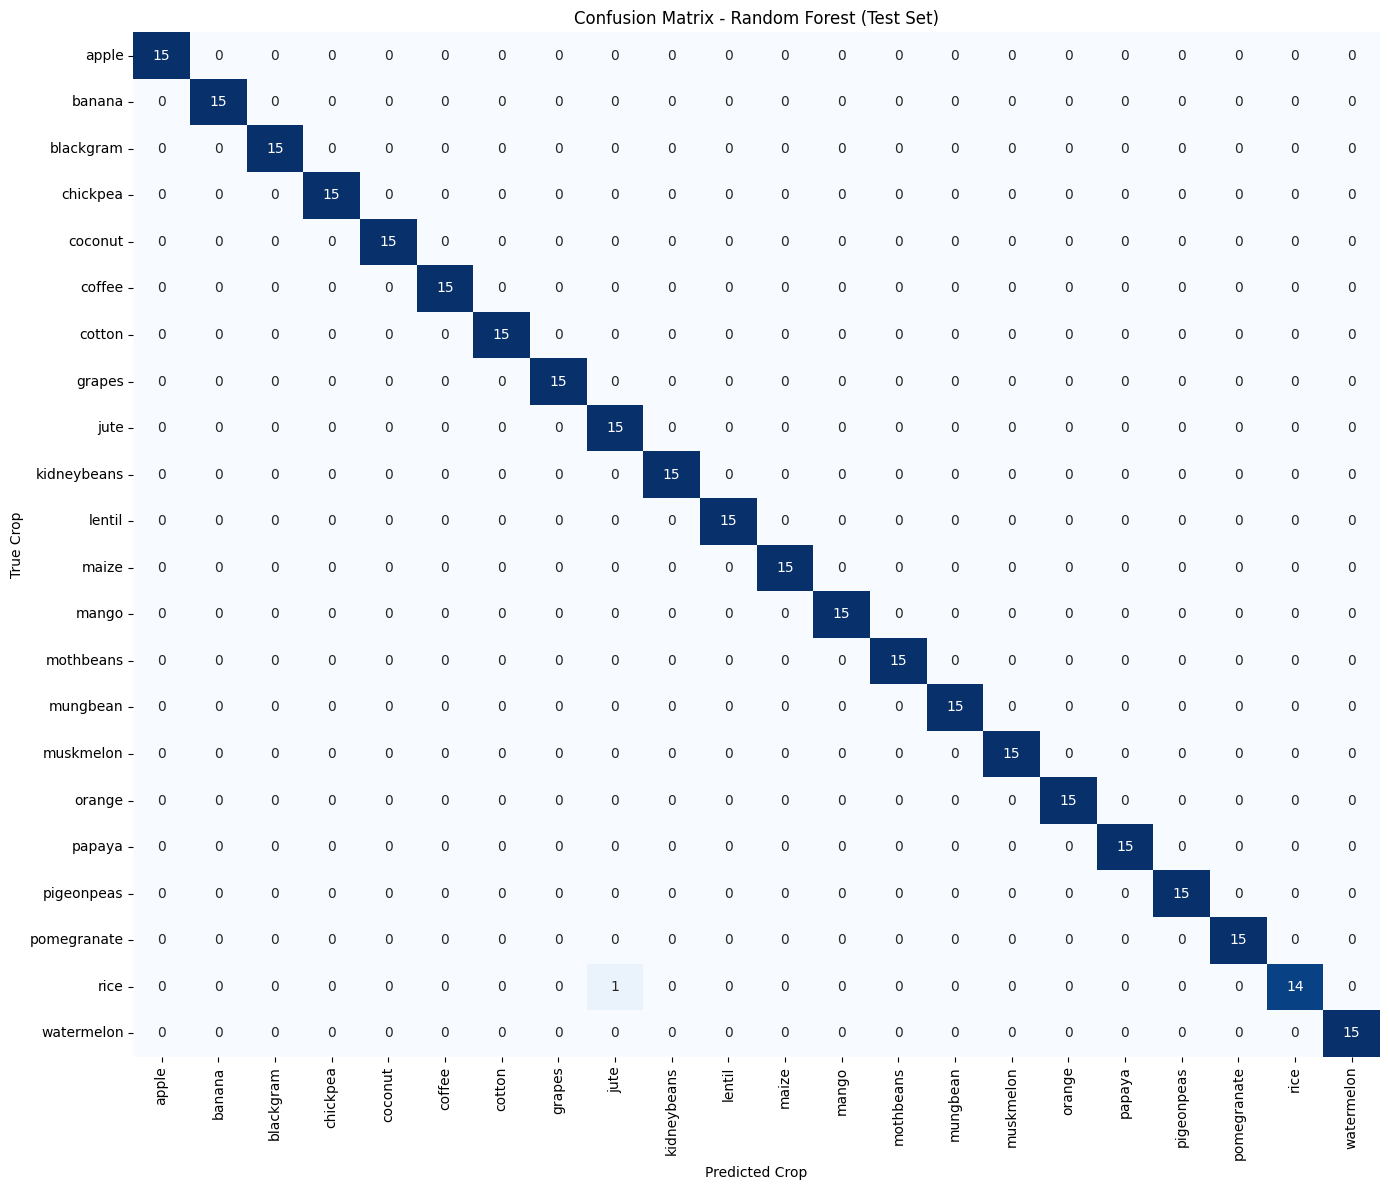

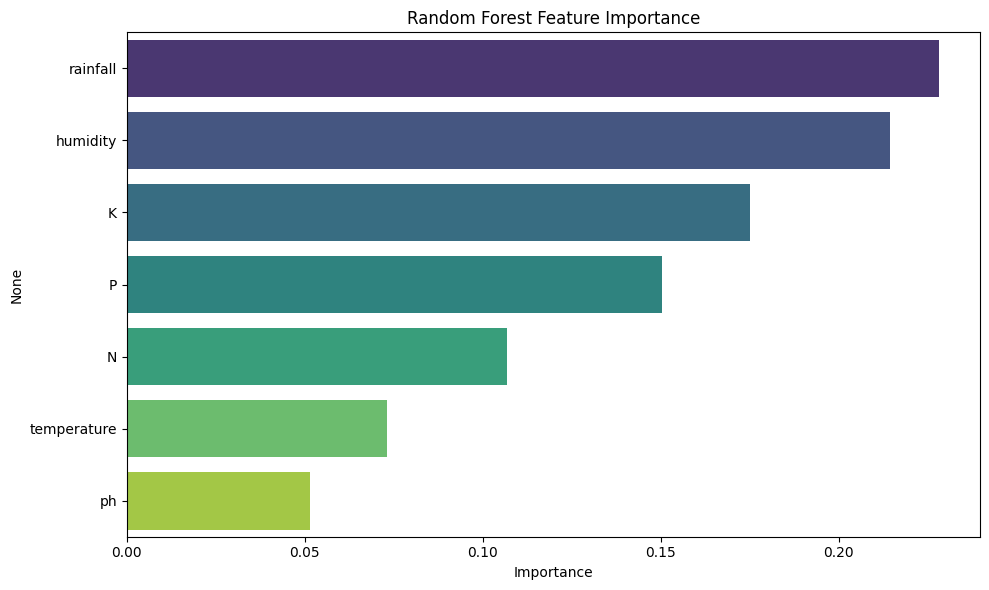


Final Random Forest model saved as 'best_crop_model.pkl'


['../models/feature_names.pkl']

In [13]:
# Combine train + val for final training
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

# Retrain best tuned RF on full train+val
best_rf.fit(X_train_full, y_train_full)

# Final test predictions
test_pred = best_rf.predict(X_test)

test_acc = accuracy_score(y_test, test_pred)
test_f1_macro = f1_score(y_test, test_pred, average='macro')
test_f1_weighted = f1_score(y_test, test_pred, average='weighted')

print(f"\nFINAL TEST RESULTS:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")
print(f"Test F1 Weighted: {test_f1_weighted:.4f}")

# Full classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, 
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest (Test Set)')
plt.ylabel('True Crop')
plt.xlabel('Predicted Crop')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_final.png')
plt.show()

# Feature Importance (bonus plot for report)
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png')
plt.show()

# Save the final model
joblib.dump(best_rf, '../models/best_crop_model.pkl')
print("\nFinal Random Forest model saved as 'best_crop_model.pkl'")

# Also save feature names for deployment reference
joblib.dump(X.columns.tolist(), '../models/feature_names.pkl')